In [1]:
import os
import datetime
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.exceptions
from sklearn.utils import class_weight
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from tensorflow.python.client import device_lib
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D, ZeroPadding2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import applications
finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"

In [2]:
[x.name for x in device_lib.list_local_devices()]
# !conda install -y -n ml ipykernel=6.23.2 numpy==1.24.0 matplotlib=3.7.1 pandas=2.0.2 seaborn=0.12.1 scikit-learn=1.3.2 tensorflow=2.11.1
# !jupyter nbconvert --to html skin-cancer-cnn.ipynb

Metal device set to: 

2023-11-27 21:12:07.963334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 21:12:07.963356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


['/device:CPU:0', '/device:GPU:0']

Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [3]:
# Train and test data paths
train_path = "dataverse_files/HAM10000_images_pca"
test_path = "dataverse_files/ISIC2018_Task3_Test_Images"

# Read the data
df = pd.read_csv('dataverse_files/HAM10000_metadata.csv')
df_test = pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
labels = df['dx'].sort_values().unique()

# Add .jpg to image_id column
df['image_id'] = df['image_id'].astype(str) + '.jpg'
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

# Drop unused columns
df=df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
df_test=df_test.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)

# 'ISIC_0035068.jpg' is missing in the test set file, lets remove it from test set dataframe
df_test = df_test[df_test['image_id'] != 'ISIC_0035068.jpg']

print(labels,'\n')

df.sort_values(by=['image_id'], inplace=True)
df.reset_index(inplace=True, drop=True)
df_test.sort_values(by=['image_id'], inplace=True)
df_test.reset_index(inplace=True, drop=True)

train_df, val_df=train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx'])
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
test_df = df_test.copy().sample(frac=1, random_state=123).reset_index(drop=True) # shuffle test set

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc'] 



In [4]:
# #To use augmented data
# train_path = "dataverse_files/HAM10000_images_pca_augmented"
# train_df = pd.read_csv('dataverse_files/HAM10000_metadata_augmented_train.csv')
# val_df = pd.read_csv('dataverse_files/HAM10000_metadata_augmented_val.csv')

In [5]:
for label in labels:
    list1 = len(train_df[train_df['dx'] == label]), len(val_df[val_df['dx'] == label]), len(test_df[test_df['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
    
train_df.shape, val_df.shape, test_df.shape

akiec  (294, 33, 43)
bcc    (463, 51, 93)
bkl    (989, 110, 217)
df     (103, 12, 44)
mel    (1002, 111, 171)
nv     (6034, 671, 908)
vasc   (128, 14, 35)


((9013, 2), (1002, 2), (1511, 2))

In [6]:
rescale=1./255
color_mode = 'rgb'
target_size = (28, 28)
batch_size  = 64
# 600 x 450
train_data_np = np.array([img_to_array(load_img(train_path+'/'+img, target_size=target_size)) for img in train_df['image_id'].values.tolist()])

datagen = ImageDataGenerator(rescale=rescale,
                            featurewise_center=True,
                            featurewise_std_normalization=True)
datagen.fit(train_data_np)
train_set = datagen.flow_from_dataframe(train_df,
                                        directory=train_path,
                                        x_col="image_id",
                                        y_col="dx",
                                        color_mode=color_mode,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False
                                        )

val_set = datagen.flow_from_dataframe(val_df,
                                      directory=train_path,
                                      x_col="image_id",
                                      y_col="dx",
                                      color_mode=color_mode,
                                      target_size=target_size,
                                      batch_size=batch_size,
                                      class_mode='categorical',
                                      shuffle=False
                                      )
test_set = datagen.flow_from_dataframe(test_df,
                                       directory=test_path,
                                       x_col="image_id",
                                       y_col="dx",
                                       color_mode=color_mode,
                                       target_size=target_size,
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       shuffle=False
                                       )

Found 9013 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.


In [7]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(filters=32, 
                 kernel_size=(3,3), 
                 input_shape=(target_size[0],target_size[1],3)
                 ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(filters=64, 
                 kernel_size=(5,5),
                ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


# Passing it to a Fully Connected layer
model.add(Flatten())

# Fully Connected layer
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully Connected layer
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Last Layer
model.add(Dense(no_of_classes, activation='softmax'))


#model.add(GlobalAveragePooling2D()) # for last cnn layer before flatten

#model.add(BatchNormalization()) # can be used for all layers except output layer (better for cnn layers)

#model.add(Dropout(0.25)) # after activation

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          5

2023-11-27 21:12:15.064855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 21:12:15.064873: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
def loss_plot(model, history, now, save=True):
    # convert the history.history dict to a pandas DataFrame:
    if type(history) is not pd.DataFrame:
        history = pd.DataFrame(history)
    if save == True:
        hist_csv_file = f'model-comparison/{now}/history.csv'
        with open(hist_csv_file, mode='w') as f:
            history.to_csv(f) 
    epochs = range(1, history.shape[0]+1)
    plt.figure(figsize=(5, 2))
    plt.plot(epochs, history['accuracy'], label='Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    max_val_acc_epoch = np.argmax(history['val_accuracy']) + 1
    max_val_acc = history['val_accuracy'][max_val_acc_epoch-1]
    label='Best Epoch = '+str(max_val_acc_epoch)+'\nVal. Acc. = '+str((max_val_acc*100).round(2))+ '%'
    plt.plot(max_val_acc_epoch, max_val_acc, 'ro', label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim([0, history.shape[0]+0.1])
    plt.ylim([0.5, 1])
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='upper left')
    if save == True:
        plt.savefig(f'model-comparison/{now}/val-acc.png')
        np.savetxt('model-comparison/{}/{}.txt'.format(now,str((max_val_acc*100).round(2))), [max_val_acc], fmt='%f')
        stats = str(now) + ' ' + str((max_val_acc*100).round(2)) + '\n'
        with open('model-comparison/best-models.txt', 'a') as f:
            f.write(stats)
    plt.show()

In [9]:
def EvaluateModel(model, test_set, str1, now, save = True):
    
    print('\n PREDICTING LABELS OF TEST IMAGES')
    result = model.predict(test_set)
    y_pred = np.argmax(result, axis=1)
    
    if save==True:
        #save y_pred to csv file
        os.mkdir('model-comparison/'+now+'/'+str1)
        np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
    
    y_true = test_set.classes # List containing true labels for each image.

    # Understanding classification power of model on each class    
    report = classification_report(y_true, y_pred, target_names=test_set.class_indices.keys())
    report_d = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=test_set.class_indices.keys())).transpose()
    report_d['support']['accuracy'] = report_d['support']['macro avg']

    annot = report_d.copy()
    annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
    annot.iloc[7, 1] = ''
    annot.iloc[7, 0] = ''
    annot['support'] = annot['support'].astype(int)

    # how to save report as image
    norm = Normalize(-1,1)
    cmap = LinearSegmentedColormap.from_list("", [[norm(-1.0), "white"],[norm( 1.0), "white"]])
    plot = sns.heatmap(report_d, annot=annot, cmap=cmap, cbar=False, fmt='')
    fig = plot.get_figure()
    if save==True:
        fig.savefig('model-comparison/{}/{}/report.png'.format(now,str1))
    
    f1_score = ((report_d['f1-score']['weighted avg']*100000//10)/100)
    accuracy = ((report_d['f1-score']['accuracy']*100000//10)/100)
    print('\nAccuracy of model prediction is: {:.2f} %'.format(accuracy))
    print('\nF1-score of model prediction is: {:.2f} %'.format(f1_score))

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_set.class_indices.keys()
                              )
    disp.plot(cmap='Reds')
    disp.ax_.set_title('Confusion Matrix')
    plt.show()
    if save==True:
        disp.figure_.savefig('model-comparison/{}/{}/cm.png'.format(now,str1))

In [10]:
def train_new_model(model):
    # Extra
    #class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_set.classes), y=train_set.classes)
    #class_weights_dict=dict(zip(np.unique(train_set.classes),class_weights))
    #keras.utils.set_random_seed(42)     
    # inside model.fit: class_weight=class_weights_dict,

    # Train new model and evaluate
    now = datetime.datetime.now().strftime("%d-%m-%H-%M")
    os.mkdir('model-comparison/'+now)
    def myprint(s):
        with open(f'model-comparison/{now}/modelsummary.txt','a') as f:
            print(s, file=f)
    model.summary(print_fn=myprint)
    with open('model-comparison/last.txt', 'w') as f:
        f.write(str(now))
    return now

Epoch 1/50


2023-11-27 21:12:20.810131: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-27 21:12:21.217184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/141 [============================>.] - ETA: 0s - loss: 1.0118 - accuracy: 0.6610

2023-11-27 21:12:29.042811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 9s 60ms/step - loss: 1.0100 - accuracy: 0.6615 - val_loss: 1.2413 - val_accuracy: 0.6717 - lr: 0.0025
Epoch 2/50
141/141 [==============================] - 8s 54ms/step - loss: 0.8376 - accuracy: 0.6924 - val_loss: 0.8823 - val_accuracy: 0.6786 - lr: 0.0025
Epoch 3/50
141/141 [==============================] - 7s 52ms/step - loss: 0.7676 - accuracy: 0.7139 - val_loss: 0.8269 - val_accuracy: 0.6966 - lr: 0.0025
Epoch 4/50
141/141 [==============================] - 7s 50ms/step - loss: 0.7066 - accuracy: 0.7360 - val_loss: 0.7865 - val_accuracy: 0.7146 - lr: 0.0025
Epoch 5/50
141/141 [==============================] - 7s 49ms/step - loss: 0.6600 - accuracy: 0.7516 - val_loss: 0.8134 - val_accuracy: 0.7066 - lr: 0.0025
Epoch 6/50
141/141 [==============================] - 7s 48ms/step - loss: 0.5930 - accuracy: 0.7732 - val_loss: 0.8793 - val_accuracy: 0.7116 - lr: 0.0025
Epoch 7/50
141/141 [==============================] - ETA: 0s - loss: 0.523

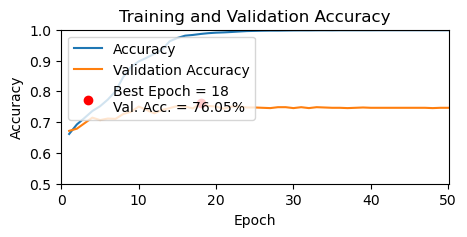


 PREDICTING LABELS OF TEST IMAGES
 3/16 [====>.........................] - ETA: 0s

2023-11-27 21:17:45.468577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 40ms/step

Accuracy of model prediction is: 76.04 %

F1-score of model prediction is: 73.77 %


/var/folders/gb/wkbd3c2d1d9dt13jt3q28bp80000gn/T/ipykernel_16158/2494306443.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'


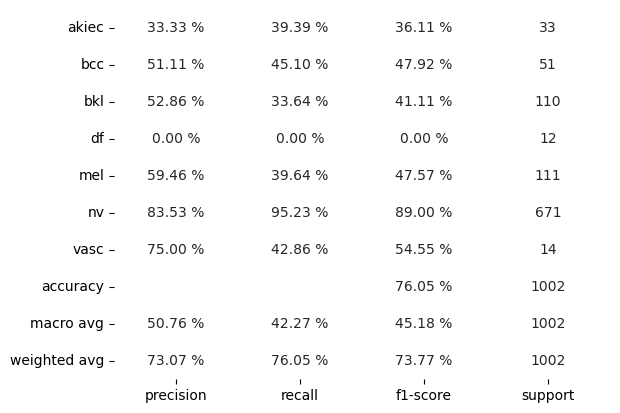

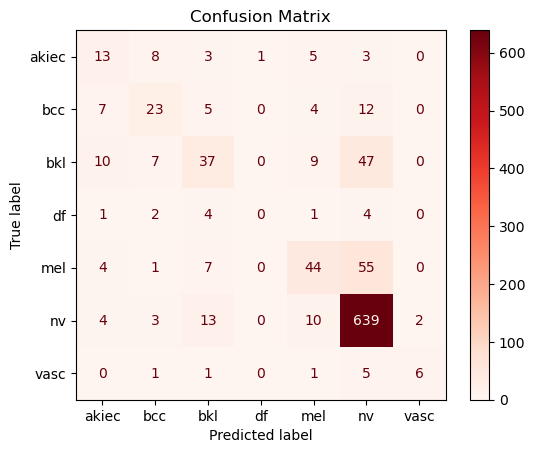


 PREDICTING LABELS OF TEST IMAGES
24/24 [==============================] - 5s 219ms/step

Accuracy of model prediction is: 66.71 %

F1-score of model prediction is: 65.00 %


/var/folders/gb/wkbd3c2d1d9dt13jt3q28bp80000gn/T/ipykernel_16158/2494306443.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'


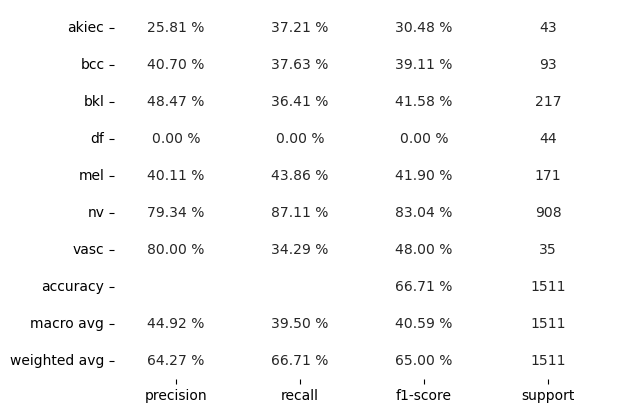

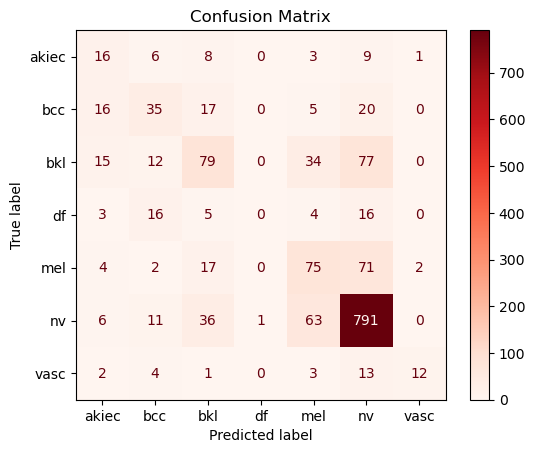

Error: AudioFileOpen failed ('wht?')


256

In [11]:
# Train new model and evaluate
now = train_new_model(model)

# Define the optimizer
optimizer = Adam(learning_rate=0.01*(batch_size/256), beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = SGD(learning_rate=0.01*(batch_size/256), momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0000001)
checkpoint = ModelCheckpoint(f"model-comparison/{now}/model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=50, mode='max', restore_best_weights=True)

history = model.fit(train_set,
                    epochs=50,
                    validation_data = val_set,
                    callbacks=[reduce_lr, checkpoint, early_stop],
                    )

loss_plot(model, history.history, now)

model = load_model(f"model-comparison/{now}/model.h5")
EvaluateModel(model, val_set, 'val', now)
EvaluateModel(model, test_set, 'test', now)

#os.system(finish_sound)

In [13]:
# model = load_model(f"model-comparison/{now}/model.h5")
# EvaluateModel(model, val_set, 'val', now)
# EvaluateModel(model, test_set, 'test', now)

In [14]:
# Load Trained Model and Evaluate

# # now = open('model-comparison/last.txt', 'r').read() 
# now = '22-11-00-37' # best model so far
# model = load_model(f"model-comparison/{now}/model.h5")
# history = pd.read_csv(f'model-comparison/{now}/history.csv')
# loss_plot(model, history, now, save=False)
# EvaluateModel(model, val_set, 'val', now, save=False)
# EvaluateModel(model, test_set, 'test', now, save=False)
